In [1]:
# Magic + imports likely common across all notebooks
%load_ext autoreload
%autoreload 2
%matplotlib inline
# Supress Warning 
import warnings
warnings.filterwarnings('ignore')
# Set reference for util modules
import sys
sys.path.append('/home/jovyan/odc-hub/')
# Generic python
import matplotlib.pyplot as plt
import numpy as np

# Bonus vector manipulation
import pandas as pd
import geopandas as gpd
from shapely import wkt
from datetime import datetime

# **Landsat-8 WOFS Product Creation**

### Config

Import required DC utils

In [2]:
import datacube
# DC utilities
from utils_dcal.data_cube_utilities.clean_mask import landsat_qa_clean_mask
from utils_dcal.data_cube_utilities.dc_water_classifier import wofs_classify
from utils_dcal.data_cube_utilities.import_export import export_xarray_to_netcdf

Define aoi via wkt polygon (could be subbed or shapefile)

In [3]:
#aoi_wkt = "POLYGON((178.12 -18.25,178.15 -18.25,178.15 -18.27,178.12 -18.27,178.12 -18.25))"
aoi_wkt = "POLYGON((178.24905395508 -18.036804199219, 178.51547241212 -18.038177490235, 178.51547241212 -18.220825195313, 178.25454711915 -18.220825195313, 178.24905395508 -18.036804199219))"
aoi = gpd.GeoDataFrame(pd.DataFrame({'geoms':[wkt.loads(aoi_wkt)]}), geometry='geoms')

In [4]:
dc = datacube.Datacube(app="na")

In [5]:
area_json = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
                aoi.bounds.minx.values[0],
                aoi.bounds.maxy.values[0]
            ],
            [
                aoi.bounds.maxx.values[0],
                aoi.bounds.maxy.values[0]
            ],
            [
                aoi.bounds.maxx.values[0],
                aoi.bounds.miny.values[0]
            ],
            [
                aoi.bounds.minx.values[0],
                aoi.bounds.miny.values[0]
            ],
            [
                aoi.bounds.minx.values[0],
                aoi.bounds.maxy.values[0]
            ]
          ]
        ]
      }
    }
  ]
}

In [6]:
lons, lats = zip(*area_json["features"][0]["geometry"]["coordinates"][0])
lat_extents = (min(lats), max(lats))
lon_extents = (min(lons), max(lons))
print("Lat:", lat_extents, "\n"
      "Lon:", lon_extents)

Lat: (-18.220825195313, -18.036804199219) 
Lon: (178.24905395508, 178.51547241212)


### Load Data

Generic query specs

In [8]:
query = dict(   latitude = lat_extents,
                longitude = lon_extents,
                output_crs = "EPSG:32760",
                time = (datetime(2018,1,1), datetime(2018,2,1)),
                resolution = (30,30))

Dataset-specifics

In [9]:
scenes = dc.load(product="ls8_usgs_sr_scene",
               group_by='solar_day',
               measurements = ["green","red","blue","nir","swir1","swir2","coastal_aerosol","pixel_qa"],
               **query)

We've been testing removal of no-data value to nan. This doesn't seem to work though as outputs from wofs over nan areas is 0, which skews the total no. observations.

In [10]:
#scenes = scenes.where(scenes != -9999.) 

Check loaded

In [11]:
print(len(scenes))

8


In [12]:
scenes.isel(time = 9).swir1.plot();

IndexError: index 9 is out of bounds for axis 0 with size 4

Create + apply 'cleansky' mask

In [95]:
clearsky_masks = landsat_qa_clean_mask(scenes, 'LANDSAT_8')
clearsky_scenes = scenes.where(clearsky_masks)

Apply wofs classification

In [96]:
water_classes = wofs_classify(clearsky_scenes, no_data = np.nan , x_coord='x', y_coord = "y")

Visualise wofs summary product

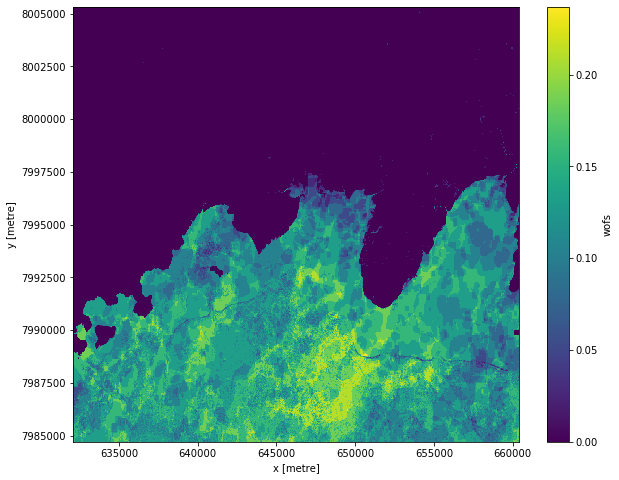

In [97]:
plt.figure(figsize = (10,8))
water_classes.wofs.mean(dim = 'time').plot();

### Export to file within shared storage

Define output path

In [98]:
# Ensure the output directory exists before writing to it.
!mkdir -p /home/shared/geo_demos/wofs_testers
output_file_name  =  "/home/shared/geo_demos/wofs_testers/l8_wofs_product_30.nc"

Correct attributes and add to wofs xarray (for some reason we have 'dc_partual_load' as true...)

In [99]:
scenes.attrs

OrderedDict([('crs', CRS('EPSG:32760'))])

In [100]:
# at = scenes.attrs
# del at['dc_partial_load']
# at

In [101]:
dataset_to_output =  water_classes.assign_attrs(scenes.attrs)

In [102]:
dataset_to_output.attrs

OrderedDict([('crs', CRS('EPSG:32760'))])

Export

In [103]:
export_xarray_to_netcdf(dataset_to_output, output_file_name)
#export_xarray_to_netcdf